In [1]:
import numpy as np
import scipy as sp
import time, sys
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

mu1,mu2a=np.meshgrid(np.linspace(0,0.3,24),np.linspace(0,0.3,24),indexing='ij')
mu1b,mu2=np.meshgrid(np.linspace(0.01,0.6,24),np.linspace(0.01,0.6,24),indexing='ij')

mu1=mu1.flatten() 
mu2=mu2.flatten()
no_para=np.size(mu1,axis=0) 

N=70
Ns=(N-1)**2
Nt=50
h=1./N
Tfinal = 1.
k=Tfinal/Nt
x1,x2=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom
u0 = 100*np.exp( -( ((x1-0.3)/0.125)**2 + ((x2-0.3)/0.125)**2) ) #IC of problem
u0 = u0.flatten()
x1=x1.flatten()
x2=x2.flatten()
t=np.linspace(0,Tfinal,Nt+1)

e=np.ones(N-1)
A1D_diff=1/h**2*sp.sparse.spdiags(np.vstack((e,-2*e,e)),[-1,0,1],N-1,N-1,format='csc') #twice differentiation
A2D_diff=sp.sparse.kron(A1D_diff,sp.sparse.eye(N-1,format='csc'),format='csc')+sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D_diff,format='csc')
A1D_conv=1/(h)*sp.sparse.spdiags(np.vstack((-1*e,1*e,0*e)),[-1,0,1],N-1,N-1,format='csc') 
A2D_conv=sp.sparse.kron(A1D_conv,sp.sparse.eye(N-1,format='csc'),format='csc') + \
         sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D_conv,format='csc')
I=sp.sparse.eye(Ns,format='csc')

# High-fidelity
U=np.zeros((Ns,no_para*Nt))
FOM_t_start=time.time()
for p in range(no_para):
    A= -mu2[p]*A2D_conv + mu1[p]*A2D_diff 
    u=np.zeros((Ns,Nt+1))
    u[:,0] = u0
    for n in range(Nt):
        u[:,n+1]=spsolve(I-k*A,u[:,n])     
    U[:,np.arange(p*Nt,(p+1)*Nt)]=u[:,1:]
FOM_t_elapsed=time.time()-FOM_t_start
# POD of solution snapshot
W,S,VT=np.linalg.svd(U)

# Generate ROM basis
ns=20
PHIs=W[:,:ns]
PHIsT=PHIs.T

# construct Djk
nt=7
D=np.zeros((ns,nt*Nt))
for i in range(ns):
    Ri=VT[i,:]
    Ri=Ri.reshape(-1,no_para,order='F')
    Wi,Si,ViT=np.linalg.svd(Ri)
    PHIti=Wi[:,:nt]
    for j in range(nt):
        D[i,Nt*j:Nt*(j+1)]=PHIti[:,j]
        
# construct PHIst
PHIst=np.zeros((Ns*Nt,ns*nt))
for i in range(Nt):
    for j in range(nt):
        PHIstij=np.zeros((Ns,ns))
        Dij=sp.sparse.diags(D[:,j*Nt+i],format='csc')
        PHIst[Ns*i:Ns*(i+1),ns*j:ns*(j+1)]=PHIs@Dij  
PHIstT=PHIst.T

# Run Space-Time ROM for arbitrary parameter
mu=[0.3,0.05] # set parameter mu
A= -mu[0]*A2D_conv + mu[1]*A2D_diff
f=np.zeros((Ns,Nt+1))

# precomputed matrices
As=PHIsT@A@PHIs
fs=PHIsT@f
ATAs = PHIsT@(I-k*A.T)@(I-k*A)@PHIs 
AIs = PHIsT@(I-k*A)@PHIs
ATIs = PHIsT@(I-k*A.T)@PHIs
ATIfs = PHIsT@(I-k*A.T)@f
ATIu0 = PHIsT@(I-k*A.T)@u0

Ast=np.zeros((ns*nt,ns*nt))
for i in range(nt):
    for j in range(nt):
        Astij=np.zeros((ns,ns))
        for kk in range(Nt):
            Dik=sp.sparse.diags(D[:,i*Nt+kk],format='csc')
            Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
            Astij += Dik@ATAs@Djk
            if kk != Nt-1:
                Dik_next=sp.sparse.diags(D[:,i*Nt+kk+1],format='csc')
                Djk_next=sp.sparse.diags(D[:,j*Nt+kk+1],format='csc')
                Astij += Dik@Djk - Dik@AIs@Djk_next - Dik_next@ATIs@Djk
        Ast[ns*i:ns*(i+1),ns*j:ns*(j+1)]=Astij  
#fst=np.zeros(ns*nt)
#for j in range(nt):
#    for kk in range(Nt):
#        Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
#        fst[ns*j:ns*(j+1)]+= k*Djk@ATIfs[:,kk+1]
#    for kk in range(Nt-1):
#        Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
#        fs_next = fs[:,kk+1+1]
#        fst[ns*j:ns*(j+1)]-=k*Djk@fs_next
ust=np.zeros(ns*nt)
for j in range(nt):
    Djk=sp.sparse.diags(D[:,j*Nt],format='csc')
    ust[ns*j:ns*(j+1)] += Djk@ATIu0
# Space-Time ROM
ROM_t_start=time.time()
UstROM=PHIst@np.linalg.solve(Ast,ust)#fst)
ROM_t_elapsed1=time.time()-ROM_t_start

# Run HF model to check error when a parameter set is arbitary
mu=[0.3,0.05] # set parameter mu
A= -mu[0]*A2D_conv + mu[1]*A2D_diff

HF_t_start=time.time()
u=np.zeros((Ns,Nt+1))
u[:,0] = u0
for n in range(Nt):
    u[:,n+1]=spsolve(I-k*A,u[:,n])#+k*f[:,n+1])
UstHF=u[:,1:].flatten(order='F')
HF_t_elapsed=time.time()-HF_t_start

In [2]:
# Print results
print('max difference1',np.max(UstHF-UstROM),'min difference1',np.min(UstHF-UstROM))
print('relative error1(%)',np.linalg.norm(UstROM-UstHF)/np.linalg.norm(UstHF)*100)
print('speed-up1',HF_t_elapsed/ROM_t_elapsed1)
print('High Fidelity Model', HF_t_elapsed)
print('ROM Model', ROM_t_elapsed1)
print('training time', FOM_t_elapsed)

#compute residual
ust0 = np.zeros(Ns*Nt)
ee = np.ones(Nt-1)
lower_diag = sp.sparse.spdiags(np.vstack((1*ee,0*ee,0*ee)),[-1,0,1],Nt,Nt,format='csc') 
Abig_st=sp.sparse.kron(sp.sparse.eye(Nt,format='csc'),(I-k*A),format='csc') + \
       sp.sparse.kron(lower_diag,-I,format='csc') 
residual = Abig_st@UstROM-ust0
normalized_residual = residual/np.linalg.norm(residual)
print('Normalized Residual',np.max(np.abs(normalized_residual)))

max difference1 0.03303136184330335 min difference1 -0.026122379962363773
relative error1(%) 0.1118146298731003
speed-up1 36.28455349318888
High Fidelity Model 0.10859489440917969
ROM Model 0.002992868423461914
training time 61.24179410934448
Normalized Residual 0.12772165460598328


0.0004415895459911765


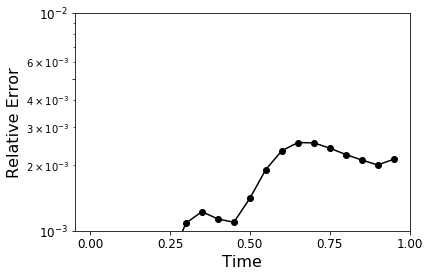

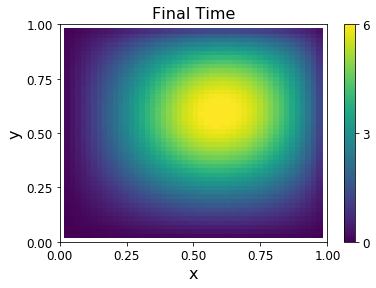

In [3]:
import os
save_figures = False
directory = 'plots2'
#if directory doesn't exist, create it
if save_figures:
    if not os.path.exists(os.path.join(os.getcwd(), directory)):
        os.mkdir(os.path.join(os.getcwd(), directory))

U_orig = np.reshape(UstHF,(Ns,Nt),order="F") #UstHF.reshape(Ns,Nt)
U_ROM = np.reshape(UstROM,(Ns,Nt),order="F")
u_orig = u[:,1:]
xx,yy=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom

relative_error = np.zeros(Nt)
for i in range(Nt):
    relative_error[i] = np.linalg.norm(U_ROM[:,i]-U_orig[:,i])/np.linalg.norm(U_orig[:,i]) 
    #relative_error[i] = np.max(np.abs(U_ROM[:,i]-U_orig[:,i]))/np.linalg.norm(U_orig[:,i])
    
plt.figure()
time = np.arange(Nt)*k
plt.semilogy(time,relative_error,'k-o')
plt.xlabel(r'Time',fontsize=16)
plt.ylabel(r'Relative Error',fontsize=16)
plt.xticks([0,0.25,0.5,0.75,1.0],fontsize=12)
plt.yticks([1e-3,5e-3,1e-2],fontsize=12)
plt.ylim([1e-3,1e-2])
np.savetxt(os.path.join(os.getcwd(), directory,"relative_error_file.txt"),relative_error)
print(relative_error[0])
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "petrovgalerkin_error_vs_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()

index = 19
plt.figure()
plt.pcolormesh(xx,yy,U_ROM[:,index].reshape(N-1,N-1),linewidth=0,rasterized=True)
#plt.colorbar()
plt.clim(0, 6)
cbar = plt.colorbar(ticks=[0,3,6])#, label=['0','-0.005','-0.010','-0.015'])
cbar.ax.tick_params(labelsize=12) 
plt.xlabel(r'x',fontsize=16)
plt.ylabel(r'y',fontsize=16)
plt.title(r'Final Time',fontsize=16)
plt.xticks([0,0.25,0.50,0.75,1.0],fontsize=12)
plt.yticks([0,0.25,0.50,0.75,1.0],fontsize=12)
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "petrovgalerkin_pcolor_final_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()